# Explanatory Data Analysis
Ali Zolfagharian

# Libraries, connecting to data source

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pickle

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/dataiku

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/dataiku


# Duplicates, missing values and outliers

reading census income learn csv files (training and test), and removing space from the beginning as it appeared in raw data

In [3]:
data = pd.read_csv('data/census_income_learn_edited.csv',skipinitialspace=True)
test_data = pd.read_csv('data/census_income_test_edited.csv',skipinitialspace=True)


duplicate in training set is less than .02 and we are going to delete them. Smae about test data, as it might lead to a wrong evaluation

In [4]:
print(f"duplicates of training data: {(len(data)-len(data.drop_duplicates()))/len(data)},duplicates of test data: {(len(test_data)-len(test_data.drop_duplicates()))/len(test_data)} | They have been removed.")
data = data.drop_duplicates();
test_data = test_data.drop_duplicates();

duplicates of training data: 0.016183597880946057,duplicates of test data: 0.008851065535975621 | They have been removed.


Please notice that '?' and 'Not in universe' will be cosidered as null value, however they are different as '?' is a missing value, but 'Not in universe' was not intended to have value in census, as it was not part of question. I try to keep things simpler. We remove columns from traing and test datasets

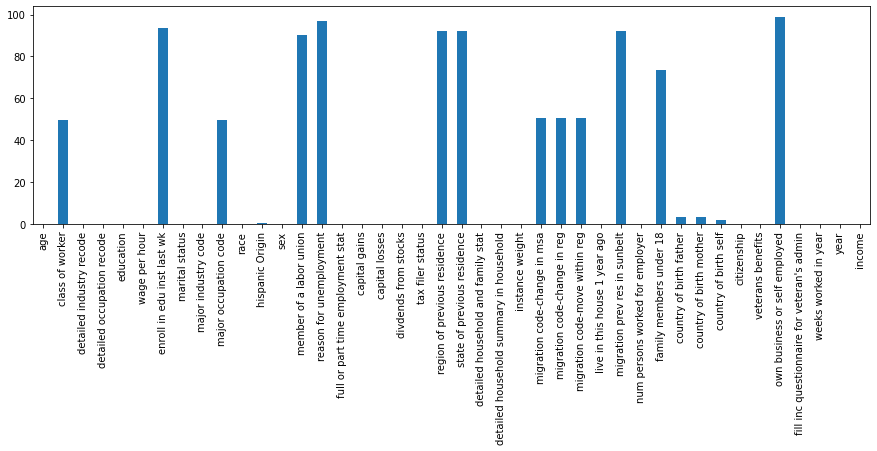

In [5]:
data = data.replace(['?','Not in universe'], np.NaN);
data_nul = (data.isna().sum()*100 / len(data))
data_nul.plot(kind='bar', figsize=(15,4))

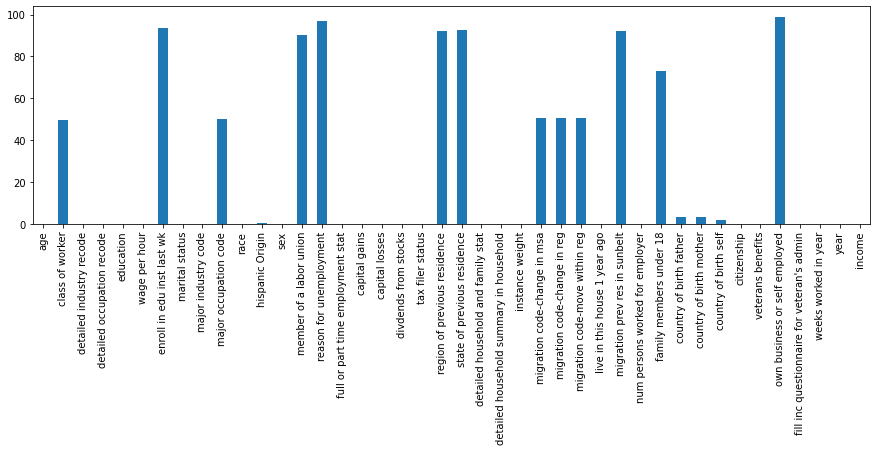

In [6]:
test_data = test_data.replace(['?','Not in universe'], np.NaN);
test_data_nul = (test_data.isna().sum()*100 / len(test_data))
test_data_nul.plot(kind='bar', figsize=(15,4))

Checking whether test and train data are similar in terms of having more than 50% missing values in some f their columns, and are they the same columns, the following shows that it is the case

In [7]:
data_missing_columns = np.array((test_data_nul[test_data_nul>30]).index.tolist())
test_data_missing_columns = np.array((data_nul[data_nul>30]).index.tolist())
if np.array_equiv(data_missing_columns,test_data_missing_columns): 
  print('same columns should be removed',data_missing_columns)

same columns should be removed ['class of worker' 'enroll in edu inst last wk' 'major occupation code'
 'member of a labor union' 'reason for unemployment'
 'region of previous residence' 'state of previous residence'
 'migration code-change in msa' 'migration code-change in reg'
 'migration code-move within reg' 'migration prev res in sunbelt'
 'family members under 18' 'own business or self employed']


In [8]:
data = data.drop(columns=data_missing_columns)
test_data = test_data.drop(columns=data_missing_columns)


# Finding optimal imputer, scaling and encoding methods

For imputer, we need them for the same columns in test and training datasets.

In [9]:

data_imp = (data.isna().sum()*100 / len(data))
test_data_imp = (test_data.isna().sum()*100 / len(test_data))
data_imp = data_imp[data_imp>0]
test_data_imp = test_data_imp[test_data_imp>0]
columns_to_impute = np.array(test_data_imp.index.tolist())
if np.array_equiv(data_imp,test_data_imp):
  print(f'same columns should be imputed : {columns_to_impute}')

"year", "fill inc questionnaire for veteran's admin", "veterans benefits", "detailed industry recode", "detailed occupation recode" columns need to be string, and need probably be encoding

In [10]:
columns_to_non_numerical = ["year", "fill inc questionnaire for veteran's admin", "veterans benefits", "detailed industry recode", "detailed occupation recode"]
for a_col in columns_to_non_numerical:
  test_data[a_col] = test_data[a_col].astype(str)
  test_data[a_col] = test_data[a_col].astype(str)
  

Outliers could be identified by boxplot, and then we decide what to do

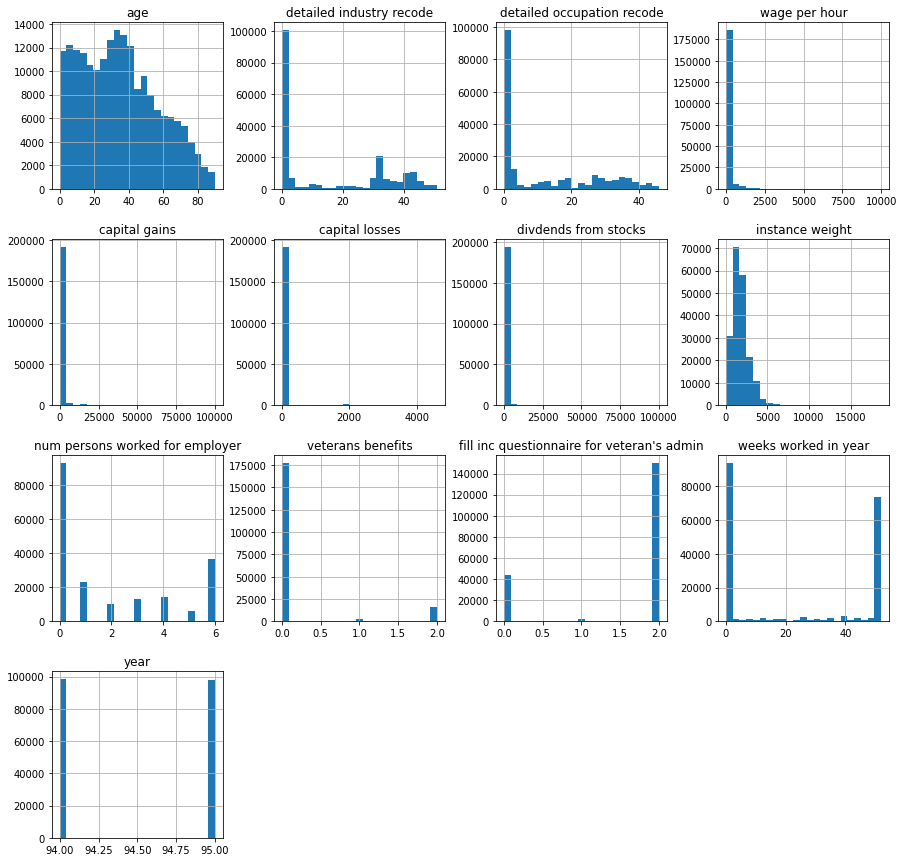

In [11]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data.select_dtypes(include=numerics).hist(figsize=(15,15),bins=23);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


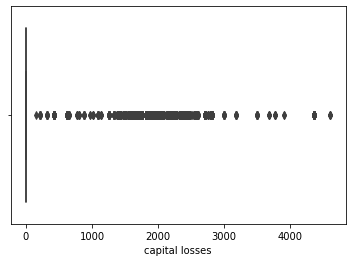

In [12]:
sns.boxplot(data['capital losses'])

In [13]:
for a_col in data.select_dtypes(include=numerics).columns.tolist():
  print(a_col);
  print(data[a_col].quantile([0.25,0.5,0.75]));

age
0.25    16.0
0.50    34.0
0.75    50.0
Name: age, dtype: float64
detailed industry recode
0.25     0.0
0.50     1.0
0.75    33.0
Name: detailed industry recode, dtype: float64
detailed occupation recode
0.25     0.0
0.50     2.0
0.75    26.0
Name: detailed occupation recode, dtype: float64
wage per hour
0.25    0.0
0.50    0.0
0.75    0.0
Name: wage per hour, dtype: float64
capital gains
0.25    0.0
0.50    0.0
0.75    0.0
Name: capital gains, dtype: float64
capital losses
0.25    0.0
0.50    0.0
0.75    0.0
Name: capital losses, dtype: float64
divdends from stocks
0.25    0.0
0.50    0.0
0.75    0.0
Name: divdends from stocks, dtype: float64
instance weight
0.25    1061.530
0.50    1620.175
0.75    2194.060
Name: instance weight, dtype: float64
num persons worked for employer
0.25    0.0
0.50    1.0
0.75    4.0
Name: num persons worked for employer, dtype: float64
veterans benefits
0.25    0.0
0.50    0.0
0.75    0.0
Name: veterans benefits, dtype: float64
fill inc questionnaire f

Should I remove those that their .25, .5 and .75 are all same number (here zero)? Let's keep it simple and let them be part of features. Following are our numerical and categorical columns

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196294 entries, 0 to 199522
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         196294 non-null  int64  
 1   detailed industry recode                    196294 non-null  int64  
 2   detailed occupation recode                  196294 non-null  int64  
 3   education                                   196294 non-null  object 
 4   wage per hour                               196294 non-null  int64  
 5   marital status                              196294 non-null  object 
 6   major industry code                         196294 non-null  object 
 7   race                                        196294 non-null  object 
 8   hispanic Origin                             195424 non-null  object 
 9   sex                                         196294 non-null  object 
 

In [28]:
data.columns.tolist()

['age',
 'detailed industry recode',
 'detailed occupation recode',
 'education',
 'wage per hour',
 'marital status',
 'major industry code',
 'race',
 'hispanic Origin',
 'sex',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'divdends from stocks',
 'tax filer status',
 'detailed household and family stat',
 'detailed household summary in household',
 'instance weight',
 'live in this house 1 year ago',
 'num persons worked for employer',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'veterans benefits',
 "fill inc questionnaire for veteran's admin",
 'weeks worked in year',
 'year',
 'income']

In [23]:
data['income'].unique()

array(['-50000', '50000+.'], dtype=object)

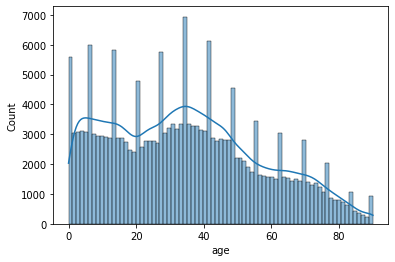

In [34]:
sns.histplot(data=data, x = 'age', kde=True)

should be seperated and devorced the same? as I do not know I ignore it

In [40]:
data['marital status'].unique()

array(['Widowed', 'Divorced', 'Never married',
       'Married-civilian spouse present', 'Separated',
       'Married-spouse absent', 'Married-A F spouse present'],
      dtype=object)

# Pipeline: preprocessing and model

Data --> Train/Validation | Test



In [30]:
X_train = data.drop(columns='income')
y_train = data['income']
y_train = y_train.replace(['-50000','50000+.'],[0,1])
X_test = test_data.drop(columns='income')
y_test = test_data['income']
y_test = y_test.replace(['-50000','50000+.'],[0,1])

In [31]:
numerical_columns = X_train.select_dtypes(include=numerics).columns.tolist()
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.tolist()
assert(len(numerical_columns)+len(categorical_columns) == len(X_train.columns.tolist()))

In [32]:
y_train.value_counts()

0    183912
1     12382
Name: income, dtype: int64

It seems data regarding target is not balanced

Here we try to make it simple by doing the following:


*   imputer: SimpleImputer (knn was also nice)
*   encoding: OneHotEncoding (no ordinal)
*   scaling: only standardScaler (no minmax)
*   model: logistic regression with auto class_weight for solving the unbalanced problem   





In [42]:
num_transformer = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())
preprocessor = make_column_transformer(
    (num_transformer, numerical_columns),
    (cat_transformer, categorical_columns),
    remainder='passthrough'
)
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=10000,class_weight="auto"))

set_config(display='diagram')
pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'detailed industry recode',
                                                   'detailed occupation recode',
                                                   'wage per hour',
                                                   'capital gains',
                                                   'capital losses',
                                                   'divdends from stocks',
                                                   'instance weight',
                                                   'num persons wo...
                                                   'major industry code',
                                                   'race', 'hispanic Origin',
                                                   'sex',
                                                   'full or part time '
                                                   'employment stat',
                                                   'tax filer status',
                                                   'detailed household and '
                                                   'family stat',
                                                   'detailed household summary '
                                                   'in household',
                                                   'live in this house 1 year '
                                                   'ago',
                                                   'country of birth father',
                                                   'country of birth mother',
                                                   'country of birth self',
                                                   'citizenship'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='auto', max_iter=10000))])

In [80]:
pipeline.fit(X_train,y_train);

In [46]:
pipeline.score(X_test,y_test)

0.9520322818798734

In [48]:
pipeline.predict(X_test.iloc[0:1])[0]

0

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
#(pipeline.steps[-1][-1].coef_[0])

In [56]:
pipeline.steps

[('columntransformer', ColumnTransformer(remainder='passthrough',
                    transformers=[('pipeline-1',
                                   Pipeline(steps=[('simpleimputer',
                                                    SimpleImputer()),
                                                   ('standardscaler',
                                                    StandardScaler())]),
                                   ['age', 'detailed industry recode',
                                    'detailed occupation recode', 'wage per hour',
                                    'capital gains', 'capital losses',
                                    'divdends from stocks', 'instance weight',
                                    'num persons worked for employer',
                                    'veterans benefits',
                                    "...
                                                    SimpleImputer(strategy='most_frequent')),
                                    

In [81]:
pipeline.named_steps['columntransformer'].transformers[1][1]['onehotencoder'].get_feature_names(categorical_columns)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


NotFittedError: ignored

In [80]:
pipeline.predict(X_test.iloc[2:3])[0]

0

In [81]:
pipeline.predict(X_test.iloc[6:7])[0]

0

It seems we have a working pipeline with plausible accuracy

In [82]:
pipeline.score(X_test, y_test)

0.9520322818798734

In [83]:
y_pred = pipeline.predict(X_test)

In [84]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

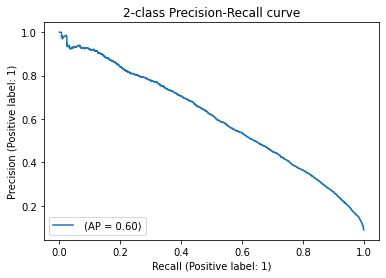

In [82]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name=""
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [86]:
table = {'accuracy': accuracy_score(y_test, y_pred),'precision': precision_score(y_test, y_pred, average="macro"),'recall': recall_score(y_test, y_pred, average="macro"),'f1_score': f1_score(y_test, y_pred, average="macro")}
table = pd.DataFrame.from_dict(table,orient='index')
table

,0
accuracy,0.952032
precision,0.840326
recall,0.685505
f1_score,0.736586


In [87]:
X_test.head(1)

,age,detailed industry recode,detailed occupation recode,education,wage per hour,marital status,major industry code,race,hispanic Origin,sex,...,live in this house 1 year ago,num persons worked for employer,country of birth father,country of birth mother,country of birth self,citizenship,veterans benefits,fill inc questionnaire for veteran's admin,weeks worked in year,year
0,38,6,36,1st 2nd 3rd or 4th grade,0,Married-civilian spouse present,Manufacturing-durable goods,White,Mexican (Mexicano),Female,...,Not in universe under 1 year old,4,Mexico,Mexico,Mexico,Foreign born- Not a citizen of U S,0,2,12,95


In [88]:
with open ('model_pickle','wb') as f:
  pickle.dump(pipeline,f)

In [89]:
X_test['age'][0]

38

In [61]:
len(X_train.columns.tolist())

28